In [1]:
import sys
import os
import os.path

import lib.matnpy.matnpyio as io
import lib.cnn.cnn as cnn 
import lib.matnpy.matnpy as matnpy
import lib.cnn.helpers as hlp

import tensorflow as tf
import numpy as np
from math import ceil

import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import datetime

In [2]:
# lib for the jupyter only
import sklearn.metrics # classification_report , confusion_matrix
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.special import erf
import itertools

for more info on the recall macro, precision macro, f-score, etc :
http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf

In [3]:
# function for the jupyter

def rapport(confusion_matrix):
    """
    This function returns performance measures for the classification tasks 
    """
    dico = {}
    classes = len(confusion_matrix)
    
    if classes == 2 :
        
        tp = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tn = cm[1][1]
        
        dico['accuracy'] = tp + tn /(tp +fn +fp +tn)
        dico['precision'] = tp/(tp +fp)
        dico['recall'] = tp/(tp + fn) # Sensitivity
        dico['Sensitivity'] = tp/(tp + fn)
        beta = 1
        dico['Fscore1'] = (beta**2 +1)*tp/( (beta**2 +1)*tp + beta**2*fn +fp )
        dico['Specificity'] = tn/ (fp + tn) # recall
        dico['AUC'] = 0.5 *( tp /(tp +fn) + tn/(tn + fp) ) # mean of accuracy per clas
    else:
        fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
        fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
        tp = np.diag(confusion_matrix)
        tn = confusion_matrix.sum() - (fp + fn + tp)

        dico['average_accuracy'] = np.mean( (tp + tn)/(tp + fn + fp + tn))
        dico['error_rate'] = np.mean( (fp + fn)/(tp +fn + fp +tn) )

        #micro


        dico['precision_micro'] = np.sum(tp) / (np.sum(tp) + np.sum(fp))
        dico['recall_micro'] = np.sum(tp) / (np.sum(tp) +np.sum(fn))
        beta = 1
        dico['Fscore1_micro'] = (beta**2+1)*dico['precision_micro'] * dico['recall_micro']/( beta **2 * dico['precision_micro']+dico['recall_micro'])

        # macro

        dico['precision_macro'] = np.mean(  tp/(tp+fp) )
        dico['recall_macro'] = np.mean(  tp/(tp+fn) )
        beta = 1
        dico['Fscore1_macro'] = (beta**2+1)*dico['precision_macro'] * dico['recall_macro']/( beta **2 * dico['precision_macro']+dico['recall_macro'])
    return(dico)

#from scipy.special import erfinv
#from scipy.special import erf

def get_mean_accuracy_per_class(confusion_matrix,  alpha = erf(1/np.sqrt(2)) ):
    """
    This function returns the mean of accuracy per class*, its error bar for a confidence interval of alpha (default at 68%),
    the accuracy per class, and the number of element of each class.
    
    it is called "recall macro" for multi-class and 'AUC' for binary-class
    """
    n_test = np.sum(confusion_matrix, axis = 1)
    
    classes = confusion_matrix.shape[0]
    
    
    #fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    tp = np.diag(confusion_matrix)
    #tn = confusion_matrix.sum() - (fp + fn + tp)
    
    #
    recall_macro_per_class = tp/(tp+fn)
    #print(recall_macro_per_class)
    #
    recall_macro = np.mean(recall_macro_per_class)
    
    # l'écart-type théorique du recall macro, soit un interval de confiance de 0.68 = erf( 1/np.sqrt(2)) --> 1 fois l'écart-type
    error_bar = np.sqrt(2) * erfinv(alpha) *np.sqrt( np.sum(recall_macro_per_class * (1 - recall_macro_per_class)/n_test) ) /classes 
    
    return(recall_macro, error_bar, recall_macro_per_class, n_test )

#import itertools
def plot_confusion_matrix(cm, classes_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_names))
    plt.xticks(tick_marks, classes_names, rotation=45)
    plt.yticks(tick_marks, classes_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

In [17]:
################################################
#                    PARAMS                    #
################################################

#################
### base path ###
#################

base_path = '/media/rudy/disk2/lucy/'

###################
### data params ###
###################

sess_no = '150210'

# path
raw_path = base_path +sess_no+'/session01/'
rinfo_path = base_path +sess_no+'/session01/' + 'recording_info.mat'
#tinfo_path = base_path +sess_no+'/session01/' + 'trial_info.mat'


# params
decode_for = 'stim'
only_correct_trials = True

align_on, from_time, to_time = 'sample', 0, 500 
lowcut, highcut, order = 80, 300, 3

#choose electrode or cortex, comment one/decomment one
#target_areas = ['V1']
target_cortex = 'Visual'
target_areas = io.get_area_cortex(rinfo_path, target_cortex, unique = True)

# either the data must be normed. 
renorm = True

In [18]:
target_areas

array(['DP', 'MT', 'V1', 'V2', 'V4t', 'V6A'], dtype='<U3')

In [19]:
##################################################
#                 CNN PARAMS                     #
##################################################


if decode_for == 'stim':

    # hyper params
    n_iterations = 100
    size_of_batches = 50
    dist = 'random_normal'
    batch_norm = 'renorm'  # 'after'
    nonlin = 'elu'
    normalized_weights = True
    learning_rate = 1e-5
    l2_regularization_penalty = 5
    keep_prob_train = .5
    
    # layer dimensions
    n_layers = 7
    patch_dim = [1, 5]  # 1xN patch
    pool_dim = [1, 2]
    in1, out1 = 1, 3
    in2, out2 = 3, 6
    in3, out3 = 6, 12
    in4, out4 = 12, 36
    in5, out5 = 36, 72
    in6, out6 = 72, 256
    in7, out7 = 256, 500
    in8, out8 = 500, 1000
    fc_units = 200

else:
    
    # hyper params
    n_iterations = 100
    size_of_batches = 50
    dist = 'random_normal'
    batch_norm = 'after'
    nonlin = 'elu'
    normalized_weights = True
    learning_rate = 1e-5
    l2_regularization_penalty = 20
    keep_prob_train = .1
    
    # layer dimensions
    n_layers = 6
    patch_dim = [1, 5]  # 1xN patch
    pool_dim = [1, 2]
    in1, out1 = 1, 3
    in2, out2 = 3, 6
    in3, out3 = 6, 12
    in4, out4 = 12, 36
    in5, out5 = 36, 72
    in6, out6 = 72, 256
    in7, out7 = 256, 500
    in8, out8 = 500, 1000
    fc_units = 200
    
    
channels_in = [in1, in2, in3, in4, in5, in6, in7, in8][:n_layers]
channels_out = [out1, out2, out3, out4, out5, out6, out7, out8][:n_layers]


##################################################
#                 TESTING PARAMS                 #
##################################################

# one_training (stratify)
train_size = .8
test_size = .2

# k_fold (stratify)
n_splits = 5 

# seed for random split
seed = 8392 #np.random.randint(1,10000)

# Auto-define number of classes
classes = 2 if decode_for == 'resp' else 5

In [20]:
##################################################
#                    GET DATA                    #
##################################################

data = matnpy.get_subset_by_areas(sess_no, raw_path,
                         align_on, from_time, to_time, 
                         lowcut, highcut, 
                         target_areas,
                         epsillon = 100, order= 3,
                         only_correct_trials = only_correct_trials, renorm = renorm, elec_type = 'grid')

n_chans = data.shape[1]
samples_per_trial = data.shape[2]

targets = io.get_targets(decode_for, raw_path, n_chans, elec_type='grid',
                         only_correct_trials=only_correct_trials,
                         onehot=True)

15021001.0001.mat
15021001.0002.mat
15021001.0003.mat
15021001.0004.mat
15021001.0005.mat
15021001.0006.mat
15021001.0007.mat
15021001.0008.mat
15021001.0009.mat
15021001.0010.mat
15021001.0011.mat
15021001.0012.mat
15021001.0013.mat
15021001.0014.mat
15021001.0015.mat
15021001.0016.mat
15021001.0017.mat
15021001.0018.mat
15021001.0019.mat
15021001.0020.mat
15021001.0021.mat
15021001.0022.mat
15021001.0023.mat
15021001.0024.mat
15021001.0025.mat
15021001.0026.mat
15021001.0027.mat
15021001.0028.mat
15021001.0029.mat
15021001.0030.mat
15021001.0031.mat
15021001.0032.mat
15021001.0033.mat
15021001.0034.mat
15021001.0035.mat
15021001.0036.mat
15021001.0037.mat
15021001.0038.mat
15021001.0039.mat
15021001.0040.mat
15021001.0041.mat
15021001.0042.mat
15021001.0043.mat
15021001.0044.mat
15021001.0045.mat
15021001.0046.mat
15021001.0047.mat
15021001.0048.mat
15021001.0049.mat
15021001.0050.mat
15021001.0051.mat
15021001.0052.mat
15021001.0053.mat
15021001.0054.mat
15021001.0055.mat
15021001.0

15021001.0454.mat
15021001.0455.mat
15021001.0456.mat
15021001.0457.mat
15021001.0458.mat
15021001.0459.mat
15021001.0460.mat
15021001.0461.mat
15021001.0462.mat
15021001.0463.mat
15021001.0464.mat
15021001.0465.mat
15021001.0466.mat
15021001.0467.mat
15021001.0468.mat
15021001.0469.mat
15021001.0470.mat
15021001.0471.mat
15021001.0472.mat
15021001.0473.mat
15021001.0474.mat
15021001.0475.mat
15021001.0476.mat
15021001.0477.mat
15021001.0478.mat
15021001.0479.mat
15021001.0480.mat
15021001.0481.mat
15021001.0482.mat
15021001.0483.mat
15021001.0484.mat
15021001.0485.mat
15021001.0486.mat
15021001.0487.mat
15021001.0488.mat
15021001.0489.mat
15021001.0490.mat
15021001.0491.mat
15021001.0492.mat
15021001.0493.mat
15021001.0494.mat
15021001.0495.mat
15021001.0496.mat
15021001.0497.mat
15021001.0498.mat
15021001.0499.mat
15021001.0500.mat
15021001.0501.mat
15021001.0502.mat
15021001.0503.mat
15021001.0504.mat
15021001.0505.mat
15021001.0506.mat
15021001.0507.mat
15021001.0508.mat
15021001.0

15021001.0908.mat
15021001.0909.mat
15021001.0910.mat
15021001.0911.mat
15021001.0912.mat
15021001.0913.mat
15021001.0914.mat
15021001.0915.mat
15021001.0916.mat
15021001.0917.mat
15021001.0918.mat
15021001.0919.mat
15021001.0920.mat
15021001.0921.mat
15021001.0922.mat
15021001.0923.mat
15021001.0924.mat
15021001.0925.mat
15021001.0926.mat
15021001.0927.mat
15021001.0928.mat
15021001.0929.mat
15021001.0930.mat
15021001.0931.mat
15021001.0932.mat
15021001.0933.mat
15021001.0934.mat
15021001.0935.mat
15021001.0936.mat
15021001.0937.mat
15021001.0938.mat
15021001.0939.mat
15021001.0940.mat
15021001.0941.mat
15021001.0942.mat
15021001.0943.mat
15021001.0944.mat
15021001.0945.mat
15021001.0946.mat
15021001.0947.mat
15021001.0948.mat
15021001.0949.mat
15021001.0950.mat
15021001.0951.mat
15021001.0952.mat
15021001.0953.mat
15021001.0954.mat
15021001.0955.mat
15021001.0956.mat
15021001.0957.mat
15021001.0958.mat
15021001.0959.mat
15021001.0960.mat
15021001.0961.mat
15021001.0962.mat
15021001.0

In [21]:
data.shape

(531, 28, 500)

In [22]:
##################################################
#                   CREATE CNN                   #
##################################################


##########
# LAYERS #
##########

# placeholders
x_ = tf.placeholder(tf.float32, shape=[
        None, n_chans, samples_per_trial
        ])
y_ = tf.placeholder(tf.float32, shape=[None, classes])
training = tf.placeholder_with_default(True, shape=())
keep_prob = tf.placeholder(tf.float32)

# Network
out, weights = cnn.create_network(
        n_layers=n_layers, 
        x_in=x_,
        n_in=channels_in, 
        n_out=channels_out, 
        patch_dim=patch_dim,
        pool_dim=pool_dim,
        training=training, 
        n_chans=n_chans,
        n_samples=samples_per_trial,
        weights_dist=dist, 
        normalized_weights=normalized_weights,
        nonlin=nonlin,
        bn=True)


###################
# FULLY-CONNECTED #
###################

# Fully-connected layer (BN)
fc1, weights[n_layers] = cnn.fully_connected(out, 
            bn=True, 
            units=fc_units,
            training=training,
            nonlin=nonlin,
            weights_dist=dist,
            normalized_weights=normalized_weights)


###################
# DROPOUT/READOUT #
###################

# Dropout (BN)
fc1_drop = tf.nn.dropout(fc1, keep_prob)

# Readout
weights[n_layers+1] = cnn.init_weights([fc_units, classes])
y_conv = tf.matmul(fc1_drop, weights[n_layers+1])
weights_shape = [tf.shape(el) for el in weights.values()]


#############
# OPTIMIZER #
#############

# Loss
loss = cnn.l2_loss(weights, 
                   l2_regularization_penalty, 
                   y_, 
                   y_conv, 
                   'loss')

# Optimizer

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
##################################################
#             TRAIN AND TEST                     #
##################################################

# SPLIT TRAIN AND TEST

# split into train and test
indices = np.arange(data.shape[0])
train, test, train_labels, test_labels, idx_train, idx_test = (
        train_test_split(
            data, 
            targets, 
            indices,
            test_size=test_size, 
            random_state=seed,
            stratify = np.argmax(targets, axis = 1)
            )
        ) 
        
ind_test = hlp.subset_test(test_labels, classes) # for a test accuracy on a balanced base


############
# TRAINING #
############

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Number of batches to train on
    for i in range(n_iterations):
        ind_train = hlp.subset_train(train_labels, classes, size_of_batches)

        # Every n iterations, print training accuracy
        if i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                    x_: train[ind_train,:,:],
                    y_: train_labels[ind_train,:],
                    keep_prob: 1.0
                    })
            print('step %d, training accuracy: %g' % (
                    i, train_accuracy))
  
        # Training
        curr_x = train[ind_train,:,:]
        curr_y = train_labels[ind_train,:]
        train_step.run(feed_dict={
                x_: curr_x,
                y_: curr_y,
                keep_prob: keep_prob_train
                })




    # Print test accuracy on a balanced base
    curr_x_test = test[ind_test,:,:]
    curr_y_test = test_labels[ind_test,:]
    
    acc_cnn = accuracy.eval(feed_dict={
            x_: curr_x_test,
            y_: curr_y_test,
            keep_prob: 1.0
            })
    
    # result on the base test
    curr_x_test = test[:,:,:]
    curr_y_test = test_labels[:,:]
    
    curr_y_predict = y_conv.eval(feed_dict={
                    x_: curr_x_test,
                    y_: curr_y_test,
                    keep_prob: 1.0
            })
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    # recall macro
    recall_macro, error_bar, recall_macro_per_class, n_test = get_mean_accuracy_per_class(confusion_matrix)
    
       
    #print('test accuracy: CNN %g ' % (acc_cnn) ) 
    print('test mean accuracy per class: %g +- %g' % (recall_macro, error_bar))

    # Get size of weights
    size_weights = sess.run(weights_shape)
    

step 0, training accuracy: 0.2
step 10, training accuracy: 0.9
step 20, training accuracy: 1
step 30, training accuracy: 1
step 40, training accuracy: 1
step 50, training accuracy: 1
step 60, training accuracy: 1
step 70, training accuracy: 1
step 80, training accuracy: 1
step 90, training accuracy: 1
test mean accuracy per class: 0.870734 +- 0.0305576


In [24]:
print(train.shape)
print(test.shape)
print(classes)

(424, 28, 500)
(107, 28, 500)
5


In [25]:
seed

8392

confusion matrix :
[[20  0  1  0  0]
 [ 0 17  0  0  1]
 [ 1  0 14  1  3]
 [ 0  0  0 24  0]
 [ 1  6  0  0 18]]
Normalized confusion matrix


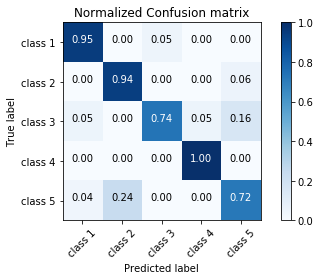


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
87.07  +-  3.06  %

Report classifier :
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        21
           1       0.74      0.94      0.83        18
           2       0.93      0.74      0.82        19
           3       0.96      1.00      0.98        24
           4       0.82      0.72      0.77        25

   micro avg       0.87      0.87      0.87       107
   macro avg       0.87      0.87      0.87       107
weighted avg       0.87      0.87      0.87       107

average_accuracy , :  0.9476635514018691
error_rate , :  0.05233644859813084
precision_micro , :  0.8691588785046729
recall_micro , :  0.8691588785046729
Fscore1_micro , :  0.8691588785046729
precision_macro , :  0.8719472990777339
recall_macro , :  0.8707335004177109
Fscore1_macro , :  0.8713399770348574


In [26]:

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

recall_macro, error_bar, recall_macro_per_class, n_test = get_mean_accuracy_per_class(confusion_matrix)

#classes_names = np.arange(1,classes+1,1)
classes_names = ['class '+str(i) for i in range(1, classes+1)]
# if decode_for == 'stim':
#     classes_names = io.get_image_names(rinfo_path)
# else: 
#     classes_names = ['fail', 'succes']

classif_report_per_class = sklearn.metrics.classification_report(y_true, y_pred, target_names=classes_names)
classif_report = rapport(confusion_matrix) 


print('confusion matrix :')
print(confusion_matrix)

plt.figure()

plot_confusion_matrix(confusion_matrix, classes_names, normalize=True, title='Normalized Confusion matrix')
plt.show()

print('\nrecall_macro (moyenne des taux de réussite de chaque classe):')
print('average per-class effectiveness of a classifier to identify class labels')
print( round(100* recall_macro, 2), ' +- ', round(100*error_bar, 2), ' %')

print('\nReport classifier :')
print(classif_report_per_class)

for key in classif_report:
    print(key,', : ',classif_report[key] )
#print(classif_report)

http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf

In [27]:
dico = rapport(sklearn.metrics.confusion_matrix(y_true, y_pred))

In [28]:
dico

{'average_accuracy': 0.9476635514018691,
 'error_rate': 0.05233644859813084,
 'precision_micro': 0.8691588785046729,
 'recall_micro': 0.8691588785046729,
 'Fscore1_micro': 0.8691588785046729,
 'precision_macro': 0.8719472990777339,
 'recall_macro': 0.8707335004177109,
 'Fscore1_macro': 0.8713399770348574}

# K-FOLD (stratifed)


In [29]:
kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=seed)

dico_fold = {}


cross_validation_i = 0
for idx_train, idx_test in kf.split(data, np.argmax(targets[:,:], axis=1)):    

    cross_validation_i += 1
    print('####################################')
    print('        FOLD NUM   ', cross_validation_i, '/',n_splits)
    print('####################################')
    
    ##################################################
    #             TRAIN AND TEST                     #
    ##################################################

    # SPLIT TRAIN AND TEST

    
    train = data[idx_train]
    test = data[idx_test]
    
    train_labels = targets[idx_train]
    test_labels = targets[idx_test]
    
    ind_test = hlp.subset_test(test_labels, classes) # for a test accuracy on a balanced base


    ############
    # TRAINING #
    ############

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Number of batches to train on
        for i in range(n_iterations):
            ind_train = hlp.subset_train(train_labels, classes, size_of_batches)

            # Every n iterations, print training accuracy
            if i % 10 == 0:
                train_accuracy = accuracy.eval(feed_dict={
                        x_: train[ind_train,:,:],
                        y_: train_labels[ind_train,:],
                        keep_prob: 1.0
                        })
                print('step %d, training accuracy: %g' % (
                        i, train_accuracy))

            # Training
            curr_x = train[ind_train,:,:]
            curr_y = train_labels[ind_train,:]
            train_step.run(feed_dict={
                    x_: curr_x,
                    y_: curr_y,
                    keep_prob: keep_prob_train
                    })




        # Print test accuracy on a balanced base
        curr_x_test = test[ind_test,:,:]
        curr_y_test = test_labels[ind_test,:]

        acc_cnn = accuracy.eval(feed_dict={
                x_: curr_x_test,
                y_: curr_y_test,
                keep_prob: 1.0
                })

        # result on the base test
        curr_x_test = test[:,:,:]
        curr_y_test = test_labels[:,:]

        curr_y_predict = y_conv.eval(feed_dict={
                        x_: curr_x_test,
                        y_: curr_y_test,
                        keep_prob: 1.0
                })
        
        # save result #
        dico_fold[cross_validation_i] = {}
        dico_fold[cross_validation_i]['curr_y_test'] = curr_y_test
        dico_fold[cross_validation_i]['curr_y_predict'] = curr_y_predict
        
        y_true = np.argmax(curr_y_test, axis = 1)
        y_pred = np.argmax(curr_y_predict, axis = 1) 
        
        confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        
        # recall macro
        recall_macro, error_bar, recall_macro_per_class, n_test = get_mean_accuracy_per_class(confusion_matrix)

#         y_true = np.argmax(curr_y_test, axis = 1)
#         y_pred = np.argmax(curr_y_predict, axis = 1) 


        #print('test accuracy: CNN %g ' % (acc_cnn) ) 
        print('test mean accuracy per class: %g +- %g' % (recall_macro, error_bar))

        # Get size of weights
        size_weights = sess.run(weights_shape)

    
    
    
    

####################################
        FOLD NUM    1 / 5
####################################
step 0, training accuracy: 0.2
step 10, training accuracy: 0.86
step 20, training accuracy: 0.98
step 30, training accuracy: 1
step 40, training accuracy: 1
step 50, training accuracy: 1
step 60, training accuracy: 1
step 70, training accuracy: 1
step 80, training accuracy: 1
step 90, training accuracy: 1
test mean accuracy per class: 0.805113 +- 0.0359725
####################################
        FOLD NUM    2 / 5
####################################
step 0, training accuracy: 0.32
step 10, training accuracy: 0.86
step 20, training accuracy: 0.92
step 30, training accuracy: 0.98
step 40, training accuracy: 1
step 50, training accuracy: 1
step 60, training accuracy: 1
step 70, training accuracy: 1
step 80, training accuracy: 1
step 90, training accuracy: 1
test mean accuracy per class: 0.838152 +- 0.0310486
####################################
        FOLD NUM    3 / 5
###############



k-Fold num° 1


confusion matrix :
[[18  0  2  1  0]
 [ 0 16  0  0  3]
 [ 5  0 10  1  3]
 [ 0  0  0 24  0]
 [ 1  4  0  0 20]]
Normalized confusion matrix


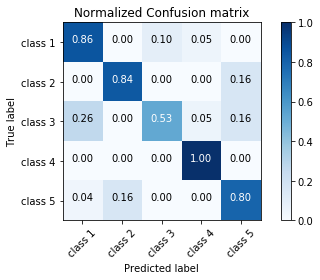


 mean accuracy per class
80.51  +-  3.6  %

Report classifier (Sklearn) :
              precision    recall  f1-score   support

     class 1       0.75      0.86      0.80        21
     class 2       0.80      0.84      0.82        19
     class 3       0.83      0.53      0.65        19
     class 4       0.92      1.00      0.96        24
     class 5       0.77      0.80      0.78        25

   micro avg       0.81      0.81      0.81       108
   macro avg       0.82      0.81      0.80       108
weighted avg       0.82      0.81      0.81       108

average_accuracy  :  0.9259259259259259
error_rate  :  0.07407407407407407
precision_micro  :  0.8148148148148148
recall_micro  :  0.8148148148148148
Fscore1_micro  :  0.8148148148148148
precision_macro  :  0.815128205128205
recall_macro  :  0.8051127819548872
Fscore1_macro  :  0.8100895386705916


k-Fold num° 2


confusion matrix :
[[21  0  0  0  0]
 [ 0 17  0  0  1]
 [ 6  0 10  1  2]
 [ 0  0  0 24  0]
 [ 1  5  1  0 18]]
Normalized

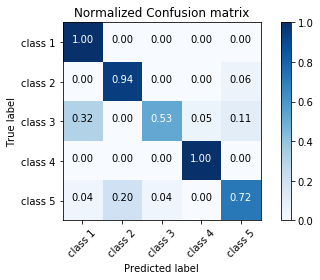


 mean accuracy per class
83.82  +-  3.1  %

Report classifier (Sklearn) :
              precision    recall  f1-score   support

     class 1       0.75      1.00      0.86        21
     class 2       0.77      0.94      0.85        18
     class 3       0.91      0.53      0.67        19
     class 4       0.96      1.00      0.98        24
     class 5       0.86      0.72      0.78        25

   micro avg       0.84      0.84      0.84       107
   macro avg       0.85      0.84      0.83       107
weighted avg       0.85      0.84      0.83       107

average_accuracy  :  0.936448598130841
error_rate  :  0.06355140186915888
precision_micro  :  0.8411214953271028
recall_micro  :  0.8411214953271028
Fscore1_micro  :  0.8411214953271028
precision_macro  :  0.8497922077922077
recall_macro  :  0.8381520467836256
Fscore1_macro  :  0.8439319916768211


k-Fold num° 3


confusion matrix :
[[18  0  1  2  0]
 [ 0 18  0  0  0]
 [ 4  0 11  2  2]
 [ 0  0  0 23  0]
 [ 1  3  0  0 21]]
Normalized

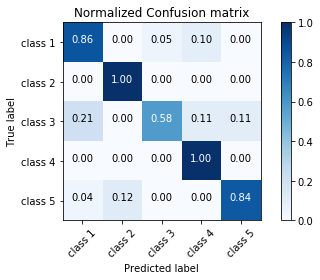


 mean accuracy per class
85.52  +-  3.1  %

Report classifier (Sklearn) :
              precision    recall  f1-score   support

     class 1       0.78      0.86      0.82        21
     class 2       0.86      1.00      0.92        18
     class 3       0.92      0.58      0.71        19
     class 4       0.85      1.00      0.92        23
     class 5       0.91      0.84      0.87        25

   micro avg       0.86      0.86      0.86       106
   macro avg       0.86      0.86      0.85       106
weighted avg       0.87      0.86      0.85       106

average_accuracy  :  0.9433962264150944
error_rate  :  0.05660377358490566
precision_micro  :  0.8584905660377359
recall_micro  :  0.8584905660377359
Fscore1_micro  :  0.8584905660377359
precision_macro  :  0.8642627099148837
recall_macro  :  0.855218045112782
Fscore1_macro  :  0.8597165895298317


k-Fold num° 4


confusion matrix :
[[21  0  0  0  0]
 [ 0 18  0  0  0]
 [ 0  0 14  3  1]
 [ 0  0  0 23  0]
 [ 0  6  1  0 18]]
Normalized

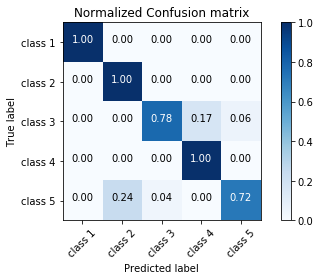


 mean accuracy per class
89.96  +-  2.66  %

Report classifier (Sklearn) :
              precision    recall  f1-score   support

     class 1       1.00      1.00      1.00        21
     class 2       0.75      1.00      0.86        18
     class 3       0.93      0.78      0.85        18
     class 4       0.88      1.00      0.94        23
     class 5       0.95      0.72      0.82        25

   micro avg       0.90      0.90      0.90       105
   macro avg       0.90      0.90      0.89       105
weighted avg       0.91      0.90      0.89       105

average_accuracy  :  0.9580952380952381
error_rate  :  0.0419047619047619
precision_micro  :  0.8952380952380953
recall_micro  :  0.8952380952380953
Fscore1_micro  :  0.8952380952380953
precision_macro  :  0.9030634278002699
recall_macro  :  0.8995555555555554
Fscore1_macro  :  0.9013060785418593


k-Fold num° 5


confusion matrix :
[[20  0  0  0  1]
 [ 0 18  0  0  0]
 [ 2  0 13  1  2]
 [ 0  0  0 23  0]
 [ 0  2  5  0 18]]
Normalize

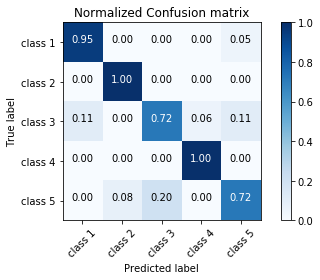


 mean accuracy per class
87.89  +-  2.92  %

Report classifier (Sklearn) :
              precision    recall  f1-score   support

     class 1       0.91      0.95      0.93        21
     class 2       0.90      1.00      0.95        18
     class 3       0.72      0.72      0.72        18
     class 4       0.96      1.00      0.98        23
     class 5       0.86      0.72      0.78        25

   micro avg       0.88      0.88      0.88       105
   macro avg       0.87      0.88      0.87       105
weighted avg       0.87      0.88      0.87       105

average_accuracy  :  0.9504761904761905
error_rate  :  0.04952380952380952
precision_micro  :  0.8761904761904762
recall_micro  :  0.8761904761904762
Fscore1_micro  :  0.8761904761904762
precision_macro  :  0.8693578643578643
recall_macro  :  0.8789206349206349
Fscore1_macro  :  0.8741130963173177


In [36]:
for key in dico_fold.keys():
    
    
        
    print('\n')
    
    print('k-Fold num°', key)
    print('\n')
    curr_y_test = dico_fold[key]['curr_y_test']
    curr_y_predict = dico_fold[key]['curr_y_predict']
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
       
    
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

    recall_macro, error_bar, recall_macro_per_class, n_test = get_mean_accuracy_per_class(confusion_matrix)
    
    
    #classes_names = np.arange(1,classes+1,1)
    classes_names = ['class '+str(i) for i in range(1, classes+1)]
    # if decode_for == 'stim':
    #     classes_names = io.get_image_names(rinfo_path)
    # else: 
    #     classes_names = ['fail', 'succes']

    classif_report_per_class = sklearn.metrics.classification_report(y_true, y_pred, target_names=classes_names)
    classif_report = rapport(confusion_matrix) 


    print('confusion matrix :')
    print(confusion_matrix)
    plt.figure()

    plot_confusion_matrix(confusion_matrix, classes_names, normalize=True, title='Normalized Confusion matrix')
    plt.show()

    print('\n mean accuracy per class')
    print( round(100* recall_macro, 2), ' +- ', round(100*error_bar, 2), ' %')

    print('\nReport classifier (Sklearn) :')
    print(classif_report_per_class)

    for key in classif_report:
        print(key,' : ',classif_report[key] )
    
    #print(classif_report)


In [31]:
### mean on k_fold result
recall_macro_per_kfold = np.zeros( (n_splits) )
error_bar_per_kfold = np.zeros( (n_splits) )
for key in dico_fold.keys():
    
    curr_y_test = dico_fold[key]['curr_y_test']
    curr_y_predict = dico_fold[key]['curr_y_predict']
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
    
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    recall_macro, error_bar, recall_macro_per_class, n_test = get_mean_accuracy_per_class(confusion_matrix)
    
    recall_macro_per_kfold[key-1] = recall_macro # key start at 1
    error_bar_per_kfold[key - 1] = error_bar
    
print('mean accuracy per class on each fold')
print(recall_macro_per_kfold )
    
print('\nMean on fold')
recall_macro_mean = np.mean(recall_macro_per_kfold)

print( round( 100 *recall_macro_mean, 1) )

print("\nError bar")
error_bar = np.sqrt( np.sum( error_bar_per_kfold**2) )/classes


print( round(100 *error_bar, 2))


    

    
    

mean accuracy per class on each fold
[0.80511278 0.83815205 0.85521805 0.89955556 0.87892063]

Mean on fold
85.5

Error bar
1.38


In [32]:
# ANOTHER WAY TO CALCULATE ERROR BAR

In [33]:
print(' emp error bar')
np.std(recall_macro_per_kfold, ddof = 1)*100/np.sqrt(n_splits)

 emp error bar


1.6323697979924174

In [34]:
# ANOTHER WAY TO CALCULATE ERROR BAR

In [35]:
confusion_matrix = []
for key in dico_fold.keys():

    curr_y_test = dico_fold[key]['curr_y_test']
    curr_y_predict = dico_fold[key]['curr_y_predict']
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
       
    
    confusion_matrix.append( sklearn.metrics.confusion_matrix(y_true, y_pred))

confusion_matrix = np.array(confusion_matrix)
confusion_matrix_all = np.sum(confusion_matrix, axis = 0)
recall_macro, error_bar, recall_macro_per_class, n_test = get_mean_accuracy_per_class(confusion_matrix_all)

print('\nMean')
print(round(100*recall_macro,1))
print('\nError bar (another way to calcultate the error bar)')
print(round(100 *error_bar, 2))


Mean
85.5

Error bar (another way to calcultate the error bar)
1.42
